# EP Tender : simulation par chaînes de Markov

## Description du modèle

On considère une station comportant $f$ files, pour un total de $n$ tenders en circulation. Chaque tender comporte $d + 1$ états de charge, numérotés de 0 à $d$. À 0 un tender est complètement déchargé, et à $d$ il est complètement chargé.

On utilise un modèle à temps discret.

Les voitures clientes arrivent de sorte que l'écart temporel entre la $i$-ième voiture et la $(i+1)$-ième est de loi géométrique de paramètre $\lambda$. Lorsqu'elles arrivent elles doivent prendre un tender complètement chargé qu'elles ramènent complètement déchargé au début de l'étape suivante.

Fatalement, un jour plus de $n$ voitures arriveront en même temps et alors la demande ne pourra pas être satisfaite. On note $T_\mathrm{bug}$ le premier temps où la demande en Tender est insatisfaite et on s'intéresse à son espérance. On cherche à trouver, pour un processus de rangement et de sélection des tenders donné, l'espérance de $T_\mathrm{bug}$, qu'on souhaite maximal.

Chaque étape temporelle se déroule comme suit :
1. Tous les tenders dans la station gagnent un niveau de charge, pour un niveau maximum de $d$.
2. Les tenders partis à l'étape précédente sont rangés dans la station.
3. Les nouvelles voitures clientes arrivent et des tenders chargés leur sont attribués.
4. Si la demande a pu être satisfaite, on passe au temps suivant.

## Importation des modules

In [1]:
import numpy as np

## Encodage des états

### Encodage d'une file simple

Une file donnée contient un certain nombre de tenders, chacun à un état de charge donné. Remarquons que les tenders les plus au fond sont ceux arrivés le plus tôt, ils sont donc les plus chargés. On peut donc représenter une file par une suite décroissante d'entiers entre 0 et $d$, de longueur au plus $n$. Si $d < n$ il peut être plus efficace d'encoder cette suite par une suite de $d + 1$ entiers positifs, de somme au plus $n$, représentant le nombre de tenders de niveau de charge $d$ dans la file, puis le nombre de tenders de niveau de charge $d - 1$, et ainsi de suite jusque $0$.

In [2]:
def encode(file, d) :
# Prend une suite décroissante d'entiers positifs entre 0 et d, et renvoie le nombre d'entiers pour chaque valeur

    fileEncodee = np.zeros(d + 1, dtype = int)
    for charge in file :
        fileEncodee[d - charge] += 1
    
    return fileEncodee

In [3]:
file = [5, 5, 3, 2, 2, 1, 0]
fileEncodee = encode(file, 6)
fileEncodee

array([0, 2, 0, 1, 2, 1, 1])

In [4]:
def decode(fileEncodee) :
    # Prend une suite d'entiers positifs, et renvoie une suite d'entiers, de longueur la somme de la suite originale
    # et prenant chaque valeur le nombre de fois indiqué par la suite de départ, de sorte à se terminer par la valeur 0
    
    d = len(fileEncodee) - 1
    file = np.zeros(sum(fileEncodee), dtype = int)
    i = 0
    for v in fileEncodee :
        while v > 0 :
            file[i] = d
            i += 1
            v -= 1
        d -= 1
    
    return file

In [5]:
decode(fileEncodee)

array([5, 5, 3, 2, 2, 1, 0])

### Encodage d'une station

Une station comportant $f$ files peut être représentée par une matrice avec $f$ éléments, chaque élément listant les états des tenders dans une file. On complète les files par des -1 pour les ramener toutes à la même longueur.

In [6]:
def encodeStation(station, d) :
    # Prend une station et renvoie la matrice comportant la valeur encodée de chaque ligne
    
    if type(station) == np.ndarray :
        station = station.tolist()
    
    stationEncodee = []
    for indexFile in range(len(station)) :
        file = station[indexFile]
        try :
            finFile = file.index(-1)
        except ValueError :
            finFile = len(file)
        stationEncodee.append(encode(file[:finFile], d))
    
    return np.array(stationEncodee, dtype = int)

In [7]:
station = [[5, 5, 3, 2, 2, 1, 0], [3, 3]]
stationEncodee = encodeStation(station, 6)
stationEncodee

array([[0, 2, 0, 1, 2, 1, 1],
       [0, 0, 0, 2, 0, 0, 0]])

In [8]:
def padStation(station) :
    # Prend une station représentée sous forme de liste et la renvoie sous forme de np.array, complété de -1
    
    if type(station) == list :
        longueurFiles = max([len(file) for file in station])
        for indexFile, file in enumerate(station) :
            station[indexFile] = file + [-1] * (longueurFiles - len(file))
    
    return np.array(station)

In [9]:
padStation(station)

array([[ 5,  5,  3,  2,  2,  1,  0],
       [ 3,  3, -1, -1, -1, -1, -1]])

In [10]:
def decodeStation(stationEncodee) :
    # Prend une station encodée et renvoie la liste de ses files décodées
    
    if type(stationEncodee) == list :
        stationEncodee = np.array(stationEncodee)
    
    station = []
    
    for indexFile in range(stationEncodee.shape[0]) :
        fileEncodee = stationEncodee[indexFile, :]
        station.append(decode(fileEncodee).tolist())
        
    return padStation(station)

In [11]:
decodeStation(stationEncodee)

array([[ 5,  5,  3,  2,  2,  1,  0],
       [ 3,  3, -1, -1, -1, -1, -1]])

## Charge des tenders

Une même fonction permet de réaliser la charge des stations et des files. Il faut néanmoins différencier le cas encodé et décodé.

In [12]:
def charge(station, d) :
    # Prend une station (décodée) et la renvoie après que chaque tender ait été chargé de 1
    
    station = station.copy()
    
    if type(station) == list :
        station = padStation(station)
        
    station += ~np.isin(station, [-1, d])    
    
    return station

In [13]:
station

[[5, 5, 3, 2, 2, 1, 0], [3, 3, -1, -1, -1, -1, -1]]

In [14]:
charge(station, 5)

array([[ 5,  5,  4,  3,  3,  2,  1],
       [ 4,  4, -1, -1, -1, -1, -1]])

In [15]:
def chargeEncodee(station) :
    # Prend une station (encodée) et la renvoie après que chaque tender ait été chargé de 1
    
    station = padStation(station)    
    chargedStation = np.zeros(station.shape)
    
    for indexFile in range(station.shape[0]) :
        chargedStation[indexFile, 0] = station[indexFile, 0]
        chargedStation[indexFile, :-1] += station[indexFile, 1:]
    
    return chargedStation

In [16]:
stationEncodee

array([[0, 2, 0, 1, 2, 1, 1],
       [0, 0, 0, 2, 0, 0, 0]])

In [17]:
chargeEncodee(stationEncodee)

array([[2., 0., 1., 2., 1., 1., 0.],
       [0., 0., 2., 0., 0., 0., 0.]])

In [18]:
chargeEncodee(chargeEncodee(chargeEncodee(stationEncodee)))

array([[3., 2., 1., 1., 0., 0., 0.],
       [2., 0., 0., 0., 0., 0., 0.]])

## Réduction du nombre de configurations pour les stations

Les états de notre chaîne de Markov sont les configurations de la station. D'un point de vue de la satisfaction de la demande, cependant, certaines configurations sont équivalentes : on peut permuter librement les files. Ainsi, on ne s'intéresse qu'aux configurations où le nombre de tenders par file est décroissant, et les files avec le même nombre de tenders sont ordonnées selon l'ordre lexicographique décroissant. Remarquons que l'ordre lexicographique est le même qu'on soit en version encodée ou décodée, en revanche la contrainte imposée par le nombre de tenders dans chaque file s'exprime différemment selon que la station est encodée ou non.

### Parcours d'ensembles de suite dans l'ordre lexicographique décroissant

Dans la suite, nous allons avoir besoin de fonctions élémentaires permettant de parcourir, dans l'ordre lexicographique décroissant, l'ensemble des suites vérifiant des contraintes données.

In [19]:
def suiteSuivanteDecSumCst(l) :
    # Permet de parcourir l'ensemble des suites décroissantes de longueur et somme données, selon l'ordre lexicographique
    # décroissant. Renvoie False quand on a atteint le dernier état.
    
    l = l.copy()
    i = len(l) - 1
    curSum = 1
    
    while i >= 0 and curSum > (l[i] - 1) * (len(l) - 1 - i):
        curSum += l[i]
        i -= 1
    
    if i >= 0 :
        l[i] -= 1
        j = i + 1
        while curSum > 0 :
            l[j] = min([curSum, l[i]])
            curSum -= l[j]
            j += 1
        while j < len(l) :
            l[j] = 0
            j += 1
    else :
        l = False
    
    return l    

In [20]:
l = [5, 4, 2, 0]
while type(l) != bool :
    print(l)
    l = suiteSuivanteDecSumCst(l)

[5, 4, 2, 0]
[5, 4, 1, 1]
[5, 3, 3, 0]
[5, 3, 2, 1]
[5, 2, 2, 2]
[4, 4, 3, 0]
[4, 4, 2, 1]
[4, 3, 3, 1]
[4, 3, 2, 2]
[3, 3, 3, 2]


In [21]:
def suiteSuivanteSumCst(l) :
    # Permet de parcourir l'ensemble des suites de longueur et somme données, selon l'ordre lexicographique
    # décroissant. Renvoie False quand on a atteint le dernier état.
    
    l = l.copy()
    
    if len(l) >= 2 :
        i = len(l) - 2
        curSum = l[i + 1]
    
        while i >= 0 :
            if l[i] >= 1 :
                l[i] -= 1
                l[i + 1] = curSum + 1
                l[(i + 2):] = [0] * (len(l) - 2 - i)
                break
            else :
                curSum += l[i]
                i -= 1
        
        if i == -1 :
            l = False
            
    else :
        l = False
    
    return l

In [22]:
l = [3, 0, 0]
while type(l) != bool :
    print(l)
    l = suiteSuivanteSumCst(l)

[3, 0, 0]
[2, 1, 0]
[2, 0, 1]
[1, 2, 0]
[1, 1, 1]
[1, 0, 2]
[0, 3, 0]
[0, 2, 1]
[0, 1, 2]
[0, 0, 3]


In [23]:
def suiteSuivanteDec(l) :
    # Permet de parcourir l'ensemble des suites décroissantes de longueur donnée, selon l'ordre lexicographique
    # décroissant. Renvoie False quand on a atteint le dernier état. On spécifie la valeur maximale en commençant par
    # d, d, d, ..., d
    
    l = l.copy()
    i = len(l) - 1
    
    while i >= 0 :
        if l[i] >= 1 :
            l[i] -= 1
            l[(i+1):] = [l[i]] * (len(l) - 1 - i)
            break
        i -= 1
        
    if i == -1 :
        l = False
    
    return l

In [24]:
l = [3, 3, 3]

while type(l) != bool :
    print(l)
    l = suiteSuivanteDec(l)

[3, 3, 3]
[3, 3, 2]
[3, 3, 1]
[3, 3, 0]
[3, 2, 2]
[3, 2, 1]
[3, 2, 0]
[3, 1, 1]
[3, 1, 0]
[3, 0, 0]
[2, 2, 2]
[2, 2, 1]
[2, 2, 0]
[2, 1, 1]
[2, 1, 0]
[2, 0, 0]
[1, 1, 1]
[1, 1, 0]
[1, 0, 0]
[0, 0, 0]


### Parcours de l'ensemble des configurations possibles pour une station

Pour les stations encodées, on a :

In [25]:
def etatEncodeSuivant(etat) :
    # Permet de parcourir l'ensemble des états possibles pour une station avec un nombre donné de tenders déjà
    # répartis entre les files, sans répéter deux états équivalents. Parcourt la répartition dans chaque file
    # dans l'ordre lexicographique décroissant. Les stations sont sous forme encodée.
    
    etat = etat.copy()
    
    nFile = etat.shape[0]
    curFile = nFile - 1
    
    while curFile >= 0 :
        file = etat[curFile, :]
        
        if type(suiteSuivanteSumCst(file)) == bool :
            file[0] = sum(file)
            file[1:] = 0
            etat[curFile, :] = file
        else :
            file = suiteSuivanteSumCst(file)
            etat[curFile, :] = file
            
            # On s'assure que les files avec le même nombre de tenders sont bien plus petites selon l'ordre lexicographique
            j = curFile + 1
            nbTenders = sum(file)
            while j < nFile and etat[j, 0] == nbTenders :
                etat[j, :] = file
            
            break

        curFile -= 1
    
    if curFile == -1 :
        etat = False
        
    return etat

In [26]:
def stationEncodeeSuivante(station) :
    # Permet de parcourir l'ensemble des états possibles pour une station avec un nombre donné de tenders,
    # sans répéter deux états équivalents. Parcourt la répartition des tenders par file selon l'ordre lexicographique
    # décroissant, puis à répartition donnée chaque file dans l'ordre lexicographique décroissant. Les stations sont sous
    # forme encodée.
    
    station = station.copy()
    
    if type(etatEncodeSuivant(station)) != bool :
        station = etatEncodeSuivant(station)
    else :
        tenderParFile = np.sum(station, axis = 1)
        if type(suiteSuivanteDecSumCst(tenderParFile)) == bool :
            station = False
        else :
            tenderParFile = suiteSuivanteDecSumCst(tenderParFile)
            station[:, :] = 0
            station[:, 0] = tenderParFile
    
    return station

In [27]:
etat = np.array([[4, 0], [0, 0]])

while type(etat) != bool :
    print(etat)
    etat = stationEncodeeSuivante(etat)

[[4 0]
 [0 0]]
[[3 1]
 [0 0]]
[[2 2]
 [0 0]]
[[1 3]
 [0 0]]
[[0 4]
 [0 0]]
[[3 0]
 [1 0]]
[[3 0]
 [0 1]]
[[2 1]
 [1 0]]
[[2 1]
 [0 1]]
[[1 2]
 [1 0]]
[[1 2]
 [0 1]]
[[0 3]
 [1 0]]
[[0 3]
 [0 1]]
[[2 0]
 [2 0]]
[[2 0]
 [1 1]]
[[2 0]
 [0 2]]
[[1 1]
 [1 1]]
[[1 1]
 [0 2]]
[[0 2]
 [0 2]]


Pour les stations décodées, on a :

In [28]:
def etatDecodeSuivant(etat, d) :
    # Permet de parcourir l'ensemble des états possibles pour une station avec un nombre donné de tenders déjà
    # répartis entre les files, sans répéter deux états équivalents. Parcourt la répartition dans chaque file
    # dans l'ordre lexicographique décroissant. Les stations sont sous forme décodée, avec des états de charge de 0 à d.
    
    etat = etat.copy()
    
    nFile = etat.shape[0]
    curFile = nFile - 1
    
    while curFile >= 0 :
        
        file = etat[curFile, :]
        try :
            finFile = file.tolist().index(-1)
        except ValueError :
            finFile = len(file)
            
        if finFile >= 1 :
            file = file[:finFile]

            if type(suiteSuivanteDec(file)) == bool :
                file[:] = d
            else :
                file = suiteSuivanteDec(file)
                etat[curFile, :finFile] = file

                # On s'assure que les files avec le même nombre de tenders sont bien plus petites selon l'ordre lexicographique
                j = curFile + 1
                while j < nFile and etat[j, finFile - 1] != -1 :
                    etat[j, :finFile] = file
                    j += 1
                
                break

        curFile -= 1
    
    if curFile == -1 :
        etat = False
        
    return etat

In [29]:
def stationDecodeeSuivante(station, d) :
    # Permet de parcourir l'ensemble des états possibles pour une station avec un nombre donné de tenders,
    # sans répéter deux états équivalents. Parcourt la répartition des tenders par file selon l'ordre lexicographique
    # décroissant, puis à répartition donnée chaque file dans l'ordre lexicographique décroissant. Les stations sont sous
    # forme encodée.
    
    station = padStation(station)
    
    if type(etatDecodeSuivant(station, d)) != bool :
        station = etatDecodeSuivant(station, d)
    else :
        tenderParFile = np.sum(station >= 0, axis = 1)
        if type(suiteSuivanteDecSumCst(tenderParFile)) == bool :
            station = False
        else :
            tenderParFile = suiteSuivanteDecSumCst(tenderParFile)
            station[:, :] = -1
            for i in range(station.shape[0]) :
                for j in range(tenderParFile[i]) :
                    station[i, j] = d
    
    return station

In [30]:
etat = padStation([[1, 1, 1, 1], []])

while type(etat) != bool :
    print(etat)
    etat = stationDecodeeSuivante(etat, 1)

[[ 1  1  1  1]
 [-1 -1 -1 -1]]
[[ 1  1  1  0]
 [-1 -1 -1 -1]]
[[ 1  1  0  0]
 [-1 -1 -1 -1]]
[[ 1  0  0  0]
 [-1 -1 -1 -1]]
[[ 0  0  0  0]
 [-1 -1 -1 -1]]
[[ 1  1  1 -1]
 [ 1 -1 -1 -1]]
[[ 1  1  1 -1]
 [ 0 -1 -1 -1]]
[[ 1  1  0 -1]
 [ 1 -1 -1 -1]]
[[ 1  1  0 -1]
 [ 0 -1 -1 -1]]
[[ 1  0  0 -1]
 [ 1 -1 -1 -1]]
[[ 1  0  0 -1]
 [ 0 -1 -1 -1]]
[[ 0  0  0 -1]
 [ 1 -1 -1 -1]]
[[ 0  0  0 -1]
 [ 0 -1 -1 -1]]
[[ 1  1 -1 -1]
 [ 1  1 -1 -1]]
[[ 1  1 -1 -1]
 [ 1  0 -1 -1]]
[[ 1  1 -1 -1]
 [ 0  0 -1 -1]]
[[ 1  0 -1 -1]
 [ 1  0 -1 -1]]
[[ 1  0 -1 -1]
 [ 0  0 -1 -1]]
[[ 0  0 -1 -1]
 [ 0  0 -1 -1]]


## Simplification supplémentaire

En fait, on remarque qu'on ne peut accéder aux tenders les plus loins dans une file qu'une fois le premier tender parti : il devra donc avoir été entièrement rechargé, et tous ceux arrivés antérieurement le seront de même. Les seules informations pertinentes pour une file sont donc le nombre de tenders présents, et le niveau de charge du plus récent arrivé.

In [31]:
def simplifie(station, encode = False) :
    # Prend une station, sa forme, encodée ou non, spécifiée par le paramètre encode (default False) et renvoie sa forme simplifiée
    
    if encode :
        newStation = np.zeros([station.shape[0], 2], dtype = int)
        for i in range(station.shape[0]) :
            curCharge = station.shape[1] - 1
            while curCharge >= 0 and station[i, curCharge] == 0 :
                curCharge -= 1
            if curCharge != -1 :
                newStation[i, 1] = station.shape[1] - 1 - curCharge
            newStation[i, 0] = np.sum(station[i, :])
    else :
        station = padStation(station)
        newStation = np.zeros([station.shape[0], 2], dtype = int)
        for i in range(station.shape[0]) :
            try :
                finFile = station[i, :].tolist().index(-1)
            except ValueError :
                finFile = station.shape[1]
            newStation[i, 0] = finFile
            if finFile >= 1 :
                newStation[i, 1] = station[i, finFile - 1]
    
    return newStation

In [32]:
simplifie([[1, 1, 1, 1], [0]])

array([[4, 1],
       [1, 0]])

In [33]:
simplifie(np.array([[4, 0], [0, 0]]), True)

array([[4, 1],
       [0, 0]])

On adapte aussi l'algorithme de charge.

In [34]:
def chargeSimplifie(station, d) :
    # Renvoie la même station simplifiée après que tous les tenders aient été chargés de 1
    
    station = station.copy()
        
    for i in range(station.shape[0]) :
        if station[i, 0] != 0 and station[i, 1] != d :
            station[i, 1] += 1
    
    return station

Lister l'ensemble des configurations possibles est désormais plus simple :

In [35]:
def etatSimplifieSuivant(station, d) :
    # Passe d'un état simplifié à l'ordre, à nombre de tenders par file donné, selon l'ordre lexicographique décroissant pour les niveaux de charge
    
    station = station.copy()
    
    curFile = station.shape[0] - 1
    
    while curFile >= 0 :
        if station[curFile, 1] >= 1 :
            station[curFile, 1] -= 1
            j = curFile + 1
            while j < station.shape[0] and station[curFile, 0] == station[j, 0] :
                station[j, 1] = station[curFile, 1]
                j += 1
            break
        elif station[curFile, 0] != 0 :
            station[curFile, 1] = d
        curFile -= 1
        
    if curFile == -1 :
        station = False
    
    return station

In [36]:
def stationSimplifieeSuivante(station, d) :
    # Permet de parcourir l'ensemble des états possibles pour une station sous forme simplifiee avec un nombre donné de tenders,
    # sans répéter deux états équivalents. Parcourt la répartition des tenders par file selon l'ordre lexicographique
    # décroissant.
    
    station = station.copy()
    
    if type(etatSimplifieSuivant(station, d)) != bool :
        station = etatSimplifieSuivant(station, d)
    else :
        tenderParFile = station[:, 0]
        if type(suiteSuivanteDecSumCst(tenderParFile)) == bool :
            station = False
        else :
            tenderParFile = suiteSuivanteDecSumCst(tenderParFile)
            station[:, 1] = d
            station[:, 0] = tenderParFile
    
    return station

In [37]:
etatSimplifie = simplifie([[2, 2, 2, 2], []])

while type(etatSimplifie) != bool :
    print(etatSimplifie)
    etatSimplifie = stationSimplifieeSuivante(etatSimplifie, 2)

[[4 2]
 [0 0]]
[[4 1]
 [0 0]]
[[4 0]
 [0 0]]
[[3 2]
 [1 2]]
[[3 2]
 [1 1]]
[[3 2]
 [1 0]]
[[3 1]
 [1 2]]
[[3 1]
 [1 1]]
[[3 1]
 [1 0]]
[[3 0]
 [1 2]]
[[3 0]
 [1 1]]
[[3 0]
 [1 0]]
[[2 2]
 [2 2]]
[[2 2]
 [2 1]]
[[2 2]
 [2 0]]
[[2 1]
 [2 1]]
[[2 1]
 [2 0]]
[[2 0]
 [2 0]]


## Liste des stations

In [38]:
def listAllStations(nTenders, nFiles, d, forme = 'simplifie') :
    listStations = []
    
    if not forme in ['decode', 'encode', 'simplifie'] :
        forme = 'simplifie'
    
    if forme == 'simplifie' :
        station = np.zeros([nFiles, 2])
        station[0, 0] = nTenders
        station[0, 1] = d

        while type(station) != bool :
            listStations.append(station)
            station = stationSimplifieeSuivante(station, d)

    elif forme == 'encode' :
        station = np.zeros([nFiles, d + 1])
        station[0, 0] = nTenders

        while type(station) != bool :
            listStations.append(station)
            station = stationEncodeeSuivante(station)
    else :
        station = padStation([[d] * nTenders] + [[]] * (nFiles - 1))

        while type(station) != bool :
            listStations.append(station)
            station = stationDecodeeSuivante(station, d)
    
    listStations.append(False) # Indique erreur
    
    return listStations

In [39]:
listAllStations(4, 2, 2)

[array([[4., 2.],
        [0., 0.]]),
 array([[4., 1.],
        [0., 0.]]),
 array([[4., 0.],
        [0., 0.]]),
 array([[3., 2.],
        [1., 2.]]),
 array([[3., 2.],
        [1., 1.]]),
 array([[3., 2.],
        [1., 0.]]),
 array([[3., 1.],
        [1., 2.]]),
 array([[3., 1.],
        [1., 1.]]),
 array([[3., 1.],
        [1., 0.]]),
 array([[3., 0.],
        [1., 2.]]),
 array([[3., 0.],
        [1., 1.]]),
 array([[3., 0.],
        [1., 0.]]),
 array([[2., 2.],
        [2., 2.]]),
 array([[2., 2.],
        [2., 1.]]),
 array([[2., 2.],
        [2., 0.]]),
 array([[2., 1.],
        [2., 1.]]),
 array([[2., 1.],
        [2., 0.]]),
 array([[2., 0.],
        [2., 0.]]),
 False]

In [40]:
listAllStations(4, 2, 2, forme = 'encode')

[array([[4., 0., 0.],
        [0., 0., 0.]]),
 array([[3., 1., 0.],
        [0., 0., 0.]]),
 array([[3., 0., 1.],
        [0., 0., 0.]]),
 array([[2., 2., 0.],
        [0., 0., 0.]]),
 array([[2., 1., 1.],
        [0., 0., 0.]]),
 array([[2., 0., 2.],
        [0., 0., 0.]]),
 array([[1., 3., 0.],
        [0., 0., 0.]]),
 array([[1., 2., 1.],
        [0., 0., 0.]]),
 array([[1., 1., 2.],
        [0., 0., 0.]]),
 array([[1., 0., 3.],
        [0., 0., 0.]]),
 array([[0., 4., 0.],
        [0., 0., 0.]]),
 array([[0., 3., 1.],
        [0., 0., 0.]]),
 array([[0., 2., 2.],
        [0., 0., 0.]]),
 array([[0., 1., 3.],
        [0., 0., 0.]]),
 array([[0., 0., 4.],
        [0., 0., 0.]]),
 array([[3., 0., 0.],
        [1., 0., 0.]]),
 array([[3., 0., 0.],
        [0., 1., 0.]]),
 array([[3., 0., 0.],
        [0., 0., 1.]]),
 array([[2., 1., 0.],
        [1., 0., 0.]]),
 array([[2., 1., 0.],
        [0., 1., 0.]]),
 array([[2., 1., 0.],
        [0., 0., 1.]]),
 array([[2., 0., 1.],
        [1.,

In [41]:
listAllStations(4, 2, 2, forme = 'decode')

[array([[ 2,  2,  2,  2],
        [-1, -1, -1, -1]]),
 array([[ 2,  2,  2,  1],
        [-1, -1, -1, -1]]),
 array([[ 2,  2,  2,  0],
        [-1, -1, -1, -1]]),
 array([[ 2,  2,  1,  1],
        [-1, -1, -1, -1]]),
 array([[ 2,  2,  1,  0],
        [-1, -1, -1, -1]]),
 array([[ 2,  2,  0,  0],
        [-1, -1, -1, -1]]),
 array([[ 2,  1,  1,  1],
        [-1, -1, -1, -1]]),
 array([[ 2,  1,  1,  0],
        [-1, -1, -1, -1]]),
 array([[ 2,  1,  0,  0],
        [-1, -1, -1, -1]]),
 array([[ 2,  0,  0,  0],
        [-1, -1, -1, -1]]),
 array([[ 1,  1,  1,  1],
        [-1, -1, -1, -1]]),
 array([[ 1,  1,  1,  0],
        [-1, -1, -1, -1]]),
 array([[ 1,  1,  0,  0],
        [-1, -1, -1, -1]]),
 array([[ 1,  0,  0,  0],
        [-1, -1, -1, -1]]),
 array([[ 0,  0,  0,  0],
        [-1, -1, -1, -1]]),
 array([[ 2,  2,  2, -1],
        [ 2, -1, -1, -1]]),
 array([[ 2,  2,  2, -1],
        [ 1, -1, -1, -1]]),
 array([[ 2,  2,  2, -1],
        [ 0, -1, -1, -1]]),
 array([[ 2,  2,  1, -1],
  

## Rangement d'une station désordonnée

### Station décodée

À faire

### Station encodée

À faire

### Station simplifiée

In [42]:
def rangeStationSimplifiee(station) :
    
    station = station.copy()
    
    maxCharge = max(station[:, 1])
    sortingTable = (maxCharge + 1) * station[:, 0] + station[:, 1]
    
    newIndices = np.argsort(sortingTable)
    
    station = station[newIndices[::-1], :]
    
    return station

In [43]:
station = np.array([[4, 2], [1, 2], [1, 3], [2, 10]])
station = rangeStationSimplifiee(station)
station

array([[ 4,  2],
       [ 2, 10],
       [ 1,  3],
       [ 1,  2]])

## Algorithmes de décision

Il nous faut maintenant décider des algorithmes de décision pour le rangement et l'attribution des tenders. On peut modéliser ces algorithmes par des fonctions $f$ qui prennent en entrée l'état de la station, $S$, et renvoient $f(S)$, l'état de la station après y avoir ajouté le tender déchargé. Plusieurs tenders peuvent arriver en même temps, avec notre modèle, on devrait donc avoir une fonction $f(S, k)$ où $k$ est le nombre de tenders qui arrivent à une étape temporelle donnée, et la valeur prise est l'état de la station après y avoir rangé tous les tenders. Cependant, en pratique, on ne voit arriver qu'une voiture à la fois, et on n'anticipe pas quand les prochaines voitures arriveront, on décide donc de manière itérative : $f(f(S, k), 1) = f(S, k + 1)$ et on n'a donc besoin de connaître que $f(S) = f(S, 1)$.

**On ne travaille pour l'instant qu'avec la version simplifiée des stations.**

### Algorithme glouton

Un algorithme naïf, qu'on qualifiera de glouton, consiste à ranger les tenders là où ils dérangent le moins, c'est à dire dans la file où le tender accessible est le moins chargé (pour ne pas bloquer l'accès aux tenders plus chargés des autres files).

De même les tenders sont prélevés dans la file contenant le moins de tenders parmi les files entièrement chargées.

Cet algorithme consiste à maximiser la durée pour laquelle on est capable de servir l'offre dans le pire des cas possible (analogie avec la statistique : estimateur min-max). Pire veut dire : on suppose qu'à la période suivante, on a le plus grand nombre de clients qu'on est capable de servir si on a fait le choix le plus favorable - puis, parmi les choix compatibles, à la période suivante, on suppose qu'on a le plus grand nombre de clients possibles, etc.
Dans la même logique, vider en priorité les files les moins remplies permet de les libérer plus vite. Ainsi, si toutes les files venaient à être remplies et chargées, nous en libérerions une plus vite et aurions donc moins de chance de devoir 'sacrifier' des tenders déjà chargés.

**N.B. : pas très compliqué de montrer que comportement cyclique - on prend toujours dans la même file, et on range toujours dans la même file (une fois toutes les files rendues non-vides), jusqu'à ce qu'on ait vidé la première file. Alors on se met à la remplir et on prélève dans une autre file (si possible)**

In [44]:
def rangementGloutonSimplifie(station) :
    
    station = station.copy()
    
    curFile = station.shape[0] - 1
    
    while curFile >= 0 and station[curFile, 0] == 0 :
        curFile -= 1
    
    if curFile == -1 :
        station[0, 0] = 1
    else :
        minCharge = min(station[:(curFile+1), 1])
        while station[curFile, 1] != minCharge :
            curFile -= 1
        
        station[curFile, 1] = 0
        station[curFile, 0] += 1
        station = rangeStationSimplifiee(station)
    
    return station

In [45]:
station

array([[ 4,  2],
       [ 2, 10],
       [ 1,  3],
       [ 1,  2]])

In [46]:
rangementGloutonSimplifie(station)

array([[ 4,  2],
       [ 2, 10],
       [ 2,  0],
       [ 1,  3]])

In [47]:
def donGloutonSimplifie(station, d) :
    
    station = station.copy()
    
    curFile = station.shape[0] - 1
    
    while curFile >= 0 and station[curFile, 1] != d :
        curFile -= 1
    
    if curFile == -1 :
        station = False
    else :
        station[curFile, 0] -= 1
        if station[curFile, 0] == 0 :
            station[curFile, 1] = 0
    
        station = rangeStationSimplifiee(station)
    
    return station

In [48]:
donGloutonSimplifie(station, 10)

array([[ 4,  2],
       [ 1, 10],
       [ 1,  3],
       [ 1,  2]])

## Création de la matrice de transition

Pour rappel, l'écart entre la date d'arrivée de la $i$-ième voiture et celle de la $(i+1)$-ième suit une loi géométrique de paramètre $\lambda$. Pour simplifier, on change (de manière équivalente) le déroulement de chaque étape temporelle comme suit :
1. Les nouvelles voitures clientes arrivent et des tenders chargés leur sont attribués.
2. Tous les tenders dans la station gagnent un niveau de charge, pour un niveau maximum de $d$.
3. Les tenders partis reviennent et sont rangés dans la station.
4. Si la demande a pu être satisfaite, on passe au temps suivant.

Pour obtenir une chaîne de Markov irréductible, on crée un nouvel état, False, qui dénote que la demande n'a pas pu être satisfaite, et à partir de cet état on repart vers un état arbitraire. On cherche donc le temps moyen pour atteindre False.

In [49]:
rng = np.random.default_rng(1964)

In [50]:
def createTransitionMatrix(listeEtat, ajout, retrait, charge, lbd) :
    
    transitionMatrix = np.zeros([len(listeEtat)] * 2)
    
    for i in range(len(listeEtat) - 1) :
        curStation = listeEtat[i]
        nClients = 0
        curProb = lbd
        
        while type(curStation) != bool :
            ghostStation = charge(curStation)
            for k in range(nClients) :
                ghostStation = ajout(ghostStation)
            j = 0
            while not (listeEtat[j] == ghostStation).all() :
                j += 1
            transitionMatrix[i, j] += curProb # Même si on reviendra pas deux fois au même état
            curProb *= (1 - lbd)
            nClients += 1
            curStation = retrait(curStation)
        
        transitionMatrix[i, len(listeEtat) - 1] = 1 - np.sum(transitionMatrix[i, :])
        
    return transitionMatrix

In [51]:
np.array([[3, 2], [1, 2]])

array([[3, 2],
       [1, 2]])

In [52]:
nTenders = 4
nFiles = 2
d = 2
listeEtat = listAllStations(nTenders, nFiles, d)
ajout = rangementGloutonSimplifie
retrait = lambda x : donGloutonSimplifie(x, d)
charge = lambda x : chargeSimplifie(x, d)
lbd = 1/2
M = createTransitionMatrix(listeEtat, ajout, retrait, charge, lbd)
print(M)

[[0.5     0.      0.46875 0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.03125]
 [0.5     0.      0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.5    ]
 [0.      0.5     0.      0.      0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.5    ]
 [0.      0.      0.46875 0.5     0.      0.      0.      0.      0.
  0.      0.      0.      0.      0.      0.      0.      0.      0.
  0.03125]
 [0.      0.      0.0625  0.5     0.      0.      0.      0.      0.
  0.125   0.      0.      0.      0.      0.25    0.      0.      0.
  0.0625 ]
 [0.      0.      0.0625  0.      0.5     0.      0.      0.      0.
  0.125   0.      0.      0.      0.      0.25    0.      0.      0.
  0.0625 ]
 [0.      0.      0.25    0.5     0.      0.      0.      0.      0.
  0.      0.      0.      0.      0. 

In [53]:
import copy

def matricetrans_glouton(nbtender,nbfiles,nbcharges,theta):
    
    stationlist=listAllStations(nbtender,nbfiles,nbcharges,d)
    
    A=[]
    
    for i in range(len(stationlist)-1):
        
        etat=stationlist[i]
        transition=[]
        
        for k in range(len(stationlist)):
            transition=transition+[0]
            
        nbvoitures=0
        bool=True
        
        while bool :
            
            if nbvoitures==0:
                etatsuiv=copy.deepcopy(etat)
                for k in range(len(etat)):
                    if etat[k][1]<nbcharges and etat[k][0]>0:
                        etatsuiv[k][1]+=1
                for num in range(len(stationlist)):
                        if (stationlist[num]==etatsuiv).all():
                            transition[num]=transition[num]+(1-theta)
                nbvoitures=1
                
            else:
                etatsuiv=copy.deepcopy(etat)
                tenderdispo=0
                for k in range(len(etat)):
                    if etat[k][1]==nbcharges:
                        tenderdispo+=etat[k][0]
                if tenderdispo<nbvoitures:
                    transition[len(transition)-1]=theta**(nbvoitures)
                    bool=False
                    
                else:
                    for numero in range(nbvoitures):                                        #on enlève les tenders
                        argmin=0
                        mini=nbtender
                        for k in range(len(etat)):
                            if etatsuiv[k][1]==nbcharges and etatsuiv[k][0]<=mini:
                                argmin=k
                                mini=etatsuiv[k][0]
                        etatsuiv[argmin][0]=etatsuiv[argmin][0]-1
                        if etatsuiv[argmin][0]==0:
                            etatsuiv[argmin][1]=0
                    for k in range(len(etat)):
                        if etatsuiv[k][1]<nbcharges and etatsuiv[k][0]>=1:
                            etatsuiv[k][1]+=1
                    for numero in range(nbvoitures):                                        #on remet les tenders
                        argmin=0
                        mini=nbcharges
                        minit=nbtender
                        for k in range(len(etat)):                                                  
                            if etatsuiv[k][1]<mini or (etatsuiv[k][1]==mini and etatsuiv[k][0]<minit):
                                argmin=k
                                mini=etatsuiv[k][1]
                                minit=etatsuiv[k][0]
                        etatsuiv[argmin][0]=etatsuiv[argmin][0]+1
                        etatsuiv[argmin][1]=0                                
                    for nombre in range(len(stationlist)-1):                #test d'égalité à permutation près
                        booleen=True 
                        station=stationlist[nombre]
                        for file in station : 
                            s=0
                            stest=0
                            for k in range(len(station)):
                                if (station[k]==file).all():  
                                    s=s+1
                                if (etatsuiv[k]==file).all():
                                    stest=stest+1
                            if s!=stest:
                                booleen=False
                        if booleen:
                            transition[nombre]+=(1-theta)*(theta**nbvoitures)
                    nbvoitures+=1
        A=A+[transition]
    transition=[]
    for k in range(len(stationlist)):
        transition=transition+[0]
    A=A+[transition]
    return(A)
        

In [67]:
m=matricetrans_glouton(4,2,2,0.5)
m

[[0.5,
  0,
  0,
  0,
  0,
  0.25,
  0,
  0,
  0,
  0.0625,
  0,
  0,
  0,
  0,
  0.125,
  0,
  0,
  0.03125,
  0.03125],
 [0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5],
 [0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5],
 [0,
  0,
  0,
  0.5,
  0,
  0.25,
  0,
  0,
  0,
  0.0625,
  0,
  0,
  0,
  0,
  0.125,
  0,
  0,
  0.03125,
  0.03125],
 [0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0.1875, 0, 0, 0, 0, 0.25, 0, 0, 0, 0.0625],
 [0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0.125, 0.0625, 0, 0, 0, 0.25, 0, 0, 0, 0.0625],
 [0, 0, 0, 0.5, 0, 0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.25],
 [0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5],
 [0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5],
 [0, 0, 0, 0, 0, 0, 0.5, 0, 0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.25],
 [0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5],
 [0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.0625,
  0,
  0,
  0.5,
  0,
  0.3

In [55]:
def normalise(matrice):
    for vecteur in matrice:
        s=0
        for j in vecteur:
            s=s+j
        if s==1:
            print(True)
        else:
            print(False)

In [56]:
def create_matrice_irr(matrice,i):
    L=[i]
    bool=True
    while bool:
        l=len(L)
        for i in L:
            for j in range(len(matrice)):
                if matrice[i][j]!=0 and (j in L)==False :
                    L=L+[j]
        if len(L)==l:
            bool=False
    mat=[]
    for i in range(len(matrice)):
        A=[]
        for j in range(len(matrice)):
            if (i in L) and (j in L):
                A=A+[matrice[i][j]]
        if len(A)>0:
            mat=mat+[A]
    return(mat,L)

In [71]:
trans=create_matrice_irr(m,len(m)-2)[0]
trans

[[0.5, 0, 0.25, 0, 0, 0.0625, 0, 0, 0, 0.125, 0, 0, 0.03125, 0.03125],
 [0.5, 0, 0, 0, 0, 0.1875, 0, 0, 0, 0.25, 0, 0, 0, 0.0625],
 [0, 0.5, 0, 0, 0, 0.125, 0.0625, 0, 0, 0.25, 0, 0, 0, 0.0625],
 [0.5, 0, 0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.25],
 [0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5],
 [0, 0, 0, 0.5, 0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0.25],
 [0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5],
 [0, 0, 0, 0, 0, 0.0625, 0, 0.5, 0, 0.375, 0, 0, 0.03125, 0.03125],
 [0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.375, 0, 0, 0, 0.125],
 [0, 0, 0, 0, 0, 0.25, 0, 0, 0.5, 0, 0, 0.125, 0, 0.125],
 [0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0.5],
 [0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0.5],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0.5],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [58]:
import numpy.linalg as alg

def resoudre_glouton(nbtender,nbfiles,nbcharges,theta):
    transition0=matricetrans_glouton(nbtender,nbfiles,nbcharges,theta)
    transition=create_matrice_irr(transition0,len(transition0)-2)[0]
    b=np.ones(len(transition))
    b[len(transition)-1]=0
    A=np.identity(len(transition))-transition   
    return(alg.solve(A,b))

In [59]:
tab=resoudre_glouton(4,2,2,0.001)
transition0=matricetrans_glouton(4,2,2,0.5)
transition=create_matrice_irr(transition0,len(transition0)-2)[0]
transition

[[0.5, 0, 0.25, 0, 0, 0.0625, 0, 0, 0, 0.125, 0, 0, 0.03125, 0.03125],
 [0.5, 0, 0, 0, 0, 0.1875, 0, 0, 0, 0.25, 0, 0, 0, 0.0625],
 [0, 0.5, 0, 0, 0, 0.125, 0.0625, 0, 0, 0.25, 0, 0, 0, 0.0625],
 [0.5, 0, 0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.25],
 [0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5],
 [0, 0, 0, 0.5, 0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0.25],
 [0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5],
 [0, 0, 0, 0, 0, 0.0625, 0, 0.5, 0, 0.375, 0, 0, 0.03125, 0.03125],
 [0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.375, 0, 0, 0, 0.125],
 [0, 0, 0, 0, 0, 0.25, 0, 0, 0.5, 0, 0, 0.125, 0, 0.125],
 [0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0.5],
 [0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0.5],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0.5],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [60]:
tab=resoudre_glouton(4,2,2,0.001)
transition0=matricetrans_glouton(4,2,2,0.5)
transition=create_matrice_irr(transition0,len(transition0)-2)[0]
transition

[[0.5, 0, 0.25, 0, 0, 0.0625, 0, 0, 0, 0.125, 0, 0, 0.03125, 0.03125],
 [0.5, 0, 0, 0, 0, 0.1875, 0, 0, 0, 0.25, 0, 0, 0, 0.0625],
 [0, 0.5, 0, 0, 0, 0.125, 0.0625, 0, 0, 0.25, 0, 0, 0, 0.0625],
 [0.5, 0, 0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.25],
 [0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5],
 [0, 0, 0, 0.5, 0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0.25],
 [0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5],
 [0, 0, 0, 0, 0, 0.0625, 0, 0.5, 0, 0.375, 0, 0, 0.03125, 0.03125],
 [0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.375, 0, 0, 0, 0.125],
 [0, 0, 0, 0, 0, 0.25, 0, 0, 0.5, 0, 0, 0.125, 0, 0.125],
 [0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0.5],
 [0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0.5],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0.5],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [61]:
def matricediff(theta):
    transition0=matricetrans_glouton(4,2,2,theta)
    transition=create_matrice_irr(transition0,len(transition0)-2)[0]
    transition[len(transition)-5][len(transition)-3]+= theta*(1-theta)
    transition[len(transition)-5][len(transition)-9]+= -theta*(1-theta)
    return(transition)


matricediff(0.5)

[[0.5, 0, 0.25, 0, 0, 0.0625, 0, 0, 0, 0.125, 0, 0, 0.03125, 0.03125],
 [0.5, 0, 0, 0, 0, 0.1875, 0, 0, 0, 0.25, 0, 0, 0, 0.0625],
 [0, 0.5, 0, 0, 0, 0.125, 0.0625, 0, 0, 0.25, 0, 0, 0, 0.0625],
 [0.5, 0, 0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.25],
 [0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5],
 [0, 0, 0, 0.5, 0.25, 0, 0, 0, 0, 0, 0, 0, 0, 0.25],
 [0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5],
 [0, 0, 0, 0, 0, 0.0625, 0, 0.5, 0, 0.375, 0, 0, 0.03125, 0.03125],
 [0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.375, 0, 0, 0, 0.125],
 [0, 0, 0, 0, 0, 0.0, 0, 0, 0.5, 0, 0, 0.375, 0, 0.125],
 [0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0, 0.5],
 [0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0, 0, 0.5],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0, 0.5],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [62]:
def resoudre(theta):
    transition=matricediff(theta)
    b=np.ones(len(transition))
    b[len(transition)-1]=0
    A=np.identity(len(transition))-transition   
    return(alg.solve(A,b))

In [78]:
for i in range(len(x)) :
    print(str(x[i]) + '\t\t\t' +  str(y1[i]))

0.01			21859900.304492507
0.02			1344581.2228173113
0.03			261505.0063798027
0.04			81504.940811715
0.05			32900.76882475829
0.060000000000000005			15644.064384168056
0.06999999999999999			8329.924496557813
0.08			4819.1045511251805
0.09			2970.767835624568
0.09999999999999999			1925.6444278833328
0.11			1300.090680366531
0.12			907.8731971132596
0.13			652.2695607287635
0.14			480.16528894451886
0.15000000000000002			360.99417693790167
0.16			276.4495267662554
0.17			215.182758043426
0.18000000000000002			169.94415030866196
0.19			135.97834549497722
0.2			110.092115285656
0.21000000000000002			90.0958122726251
0.22			74.4594223500827
0.23			62.09549993049786
0.24000000000000002			52.21911023020148
0.25			44.25562564188755
0.26			37.77890471173977
0.27			32.469142329194895
0.28			28.083686460594095
0.29000000000000004			24.436544050402016
0.3			21.38379900045021
0.31			18.813109768502873
0.32			16.636059162079672
0.33			14.782522625728124
0.34			13.196481341783645
0.35000000000000003		

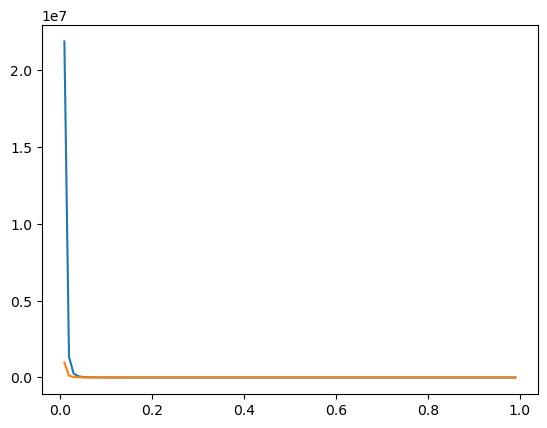

In [77]:
import matplotlib.pyplot as plt
x = np.arange(0.01, 1, 0.01)
y1=[]
y2=[]
for i in x:
    y1=y1+[resoudre_glouton(4,2,2,i)[12]]
    y2=y2+[resoudre(i)[12]]
plt.plot(x, y1)
plt.plot(x, y2)
plt.show()

In [ ]:
def numerotationtender(liste,nombre):
    s=0
    for i in liste : 
        if i<nombre:
            s+=1
    return s

In [ ]:
def matricediff5(theta):
    transition0=matricetrans_glouton(4,2,5,theta)
    trans=create_matrice_irr(transition0,len(transition0)-2)
    transition=trans[0]
    L=trans[1]
    transition[numerotationtender(L,44)][numerotationtender(L,52)]+= theta*(1-theta)
    transition[numerotationtender(L,44)][numerotationtender(L,36)]+= -theta*(1-theta)
    return(transition)

In [ ]:
def resoudre(theta):
    transition=matricediff5(theta)
    b=np.ones(len(transition))
    b[len(transition)-1]=0
    A=np.identity(len(transition))-transition   
    return(alg.solve(A,b))

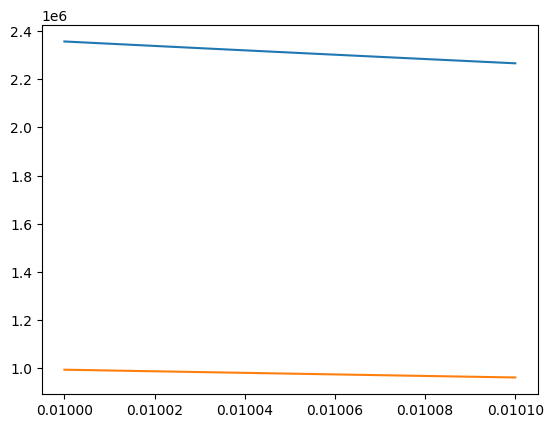

In [ ]:
import matplotlib.pyplot as plt
x = np.linspace(0.01, 0.0101, 10)
y1=[]
y2=[]
for i in x:
    y1=y1+[resoudre_glouton(4,2,5,i)[33]]
    y2=y2+[resoudre(i)[33]]
plt.plot(x, y1)
plt.plot(x, y2)
plt.show()

In [ ]:

x = np.linspace(0.01, 0.9, 100)
y=[]
for i in x:
    y=y+[[resoudre_glouton(4,2,5,i)[0],resoudre(i)[0]]]
y

[[2358242.761459019, 995794.5553191382],
 [191430.30690244058, 114641.22613439214],
 [42908.91830955082, 30174.573097068835],
 [14882.573165242591, 11483.055867742445],
 [6591.651668513823, 5401.362510318845],
 [3414.81156429753, 2917.957860549564],
 [1973.0247771701831, 1738.4207249993658],
 [1235.432971065212, 1114.0846206911622],
 [822.8307216322488, 755.5081253823962],
 [575.4700740124765, 535.9915994607543],
 [418.74124703575103, 394.5289268194086],
 [314.84667540946015, 299.4383951240475],
 [243.33531617238248, 233.22239202103205],
 [192.5228833407425, 185.70994642725273],
 [155.42109508927388, 150.72786346177017],
 [127.68382751718215, 124.38814381953286],
 [106.51543632908925, 104.16228837465836],
 [90.06392259159814, 88.35916014347072],
 [77.07022409369111, 75.81933449529174],
 [66.65848946115328, 65.73023896924859],
 [58.20681404312719, 57.51106336886551],
 [51.26539391316758, 50.739230367297516],
 [45.5034366572501, 45.10231413247064],
 [40.673966578758495, 40.36593233012913

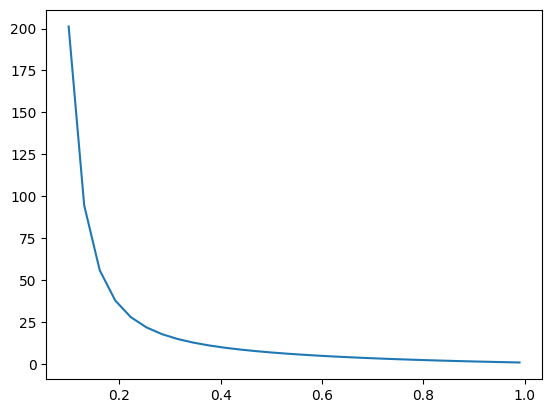

In [ ]:
x = np.linspace(0.1, 0.99, 30)
y1=[]
for i in x:
    y1=y1+[resoudre_glouton(5,2,10,i)[0]]
plt.plot(x, y1)
plt.show()

In [ ]:
def matricediff10(theta):
    transition0=matricetrans_glouton(5,2,10,theta)
    trans=create_matrice_irr(transition0,len(transition0)-2)
    transition=trans[0]
    L=trans[1]
    transition[numerotationtender(L,154)][numerotationtender(L,153)]+= theta*(1-theta)
    transition[numerotationtender(L,154)][numerotationtender(L,121)]+= -theta*(1-theta)
    return(transition)

In [ ]:
def positif(matrice):
    booleen=True
    for i in matrice:
        for j in i :
            if j<0:
                return False
    return True

In [ ]:
m=matricediff10(0.5)
positif(m)

133


True

In [ ]:
def resoudre10(theta):
    transition=matricediff10(theta)
    b=np.ones(len(transition))
    b[len(transition)-1]=0
    A=np.identity(len(transition))-transition   
    return(alg.solve(A,b))

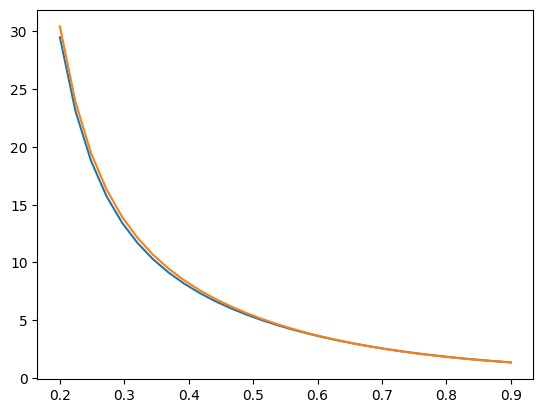

In [ ]:

x = np.linspace(0.2, 0.9, 30)
y1=[]
y2=[]
for i in x:
    y1=y1+[resoudre_glouton(5,2,10,i)[133]]
    y2=y2+[resoudre10(i)[133]]
plt.plot(x, y1)
plt.plot(x, y2)
plt.show()

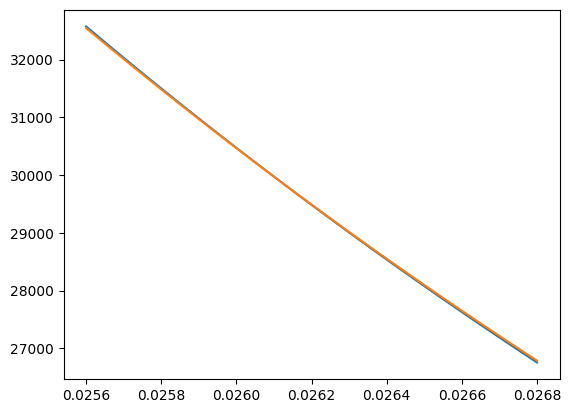

In [ ]:
x = np.linspace(0.0256, 0.0268, 20)
y1=[]
y2=[]
for i in x:
    y1=y1+[resoudre_glouton(5,2,10,i)[133]]
    y2=y2+[resoudre10(i)[133]]
plt.plot(x, y1)
plt.plot(x, y2)
plt.show()